# Realisez des indexations automatiques d'images

# SOMMAIRE

* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [DATASET](#CHARGEMENT)
* [CNN](#CNN)
    * [CUSTOM MODEL](#CUSTOM_MODEL)
    * [VGG16](#VGG16)
    * [VGG19](#VGG19)
    * [RESNET50](#RESNET50)
    * [Layers visualization](#Layers-visualization)

# PREPARATION

## Import des librairies

In [44]:
import re
import joblib
import cv2
import glob
import numpy as np

import matplotlib.pyplot as plt
import random

import keras
import tensorflow as tf
import pydot
import graphviz

from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from sklearn. model_selection import train_test_split

## Paramètrage du notebook

## Déclaration des fonctions

In [2]:
from keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten
from keras.models import Model

def conv3x3(input_x,nb_filters):
    """
    Wrapper around convolution layer
    Inputs:
        input_x: input layer / tensor
        nb_filter: Number of filters for convolution
    """
    return Conv2D(nb_filters, kernel_size=(3,3), use_bias=False,
               activation='relu', padding="same",input_shape=(128, 128, 3))(input_x)

def std_image(image):
        image=image.astype('float32') # convert from integers to floats
        image-= image.mean()
        image/= image.std ()
        image*=  64
        image+= 128
        image/=255 # normalize to the range 0-1
        return image

def create_model(img_h=128, img_w=128):
    """
    Creates a CNN model for training. 
    Inputs: 
        img_h: input image height
        img_w: input image width
    Returns:
        Model structure 
    """
    
    inputs = Input(shape=(img_h, img_w, 3))

    x = conv3x3(inputs, 32)
    x = conv3x3(x, 32)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = conv3x3(x, 64)
    x = conv3x3(x, 64)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = conv3x3(x, 128)
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    preds = Dense(nb_class, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=preds)
    model.compile(
    #loss=keras.losses.categorical_crossentropy,
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
    print(model.summary())
    return model

In [3]:
#tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

def create_model_2(img_h=128, img_w=128): # Creation du modele
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32,
        (3,3),
        input_shape=(img_h,img_w,3), 
        activation='relu',
        padding='same'
        ))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    model.add(tf.keras.layers.Conv2D(64,
        (3,3),
        activation='relu',
        padding='same'
        ))
    model.add(tf.keras.layers.MaxPooling2D(2,2))

    
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(120,
        activation='softmax'))
    model.compile(
    #loss=keras.losses.categorical_crossentropy,
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
    print(model.summary())
    return model

In [4]:
#tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

def create_model_3(img_h=128, img_w=128): # Creation du modele
    model = tf.keras.models.Sequential()
    model.add(keras.Input(shape=(img_h, img_w, 3)))
    #model.add(tf.keras.layers.Rescaling(1./255))
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(120, activation="softmax"))
    model.compile(
    #loss=keras.losses.categorical_crossentropy,
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
    print(model.summary())
    return model

In [5]:
def create_model_vgg16(img_h=128, img_w=128):
    vgg = VGG16(input_shape=(img_h, img_w, 3), weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(120, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model

In [6]:
def create_model_vgg19(img_h=128, img_w=128):
    vgg = VGG19(input_shape=(img_h, img_w, 3), weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(120, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model

In [7]:
def create_model_resnet50(img_h=128, img_w=128):
    resnet50 = ResNet50(input_shape=(img_h, img_w, 3), weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in resnet50.layers:
        layer.trainable = False
     
    # get the resnet output
    out = resnet50.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
#    x = Dense(100, activation='relu')(x)
#    x = Dense(100, activation='relu')(x)
#    x = Dense(100, activation='relu')(x)
    x = Dense(120, activation='softmax')(x)
     
    model = Model(inputs=resnet50.input, outputs=x)
     
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model

# CHARGEMENT

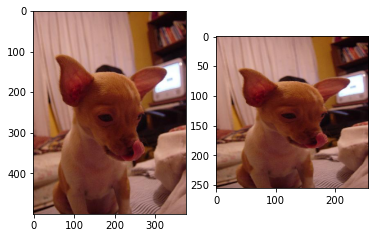

In [8]:
# DEBUG - comparaison entre l'original et l'image retaillée

imgs=[]

for img in glob.glob("/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/n02085620-Chihuahua/*.jpg"):
    #print(img)
    i=cv2.imread(img,cv2.IMREAD_COLOR)
    imgs.append(i)

original=imgs[35][:,:,::-1] #opencv defaults read color into BGR -> convert to RGB
resized=cv2.resize(original, (256, 256),interpolation = cv2.INTER_NEAREST)
plt.subplot(1, 2, 1)
plt.imshow(original)

plt.subplot(1, 2, 2)
plt.imshow(resized)

plt.show()

In [9]:
# liste des fichiers
#filelist=glob.glob('/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/n02085620-Chihuahua/*.jpg')
filelist=glob.glob('/Users/hui-guan/Documents/Projet/Reskill/Projet7/Dataset/Images/*/*.jpg')

# DATASET

In [10]:
# chargement des labels (a partir des noms de repertoires)

dogTypes=[]
for file in filelist:
    #print(f"[{i}]-{file}")
    d=re.match("\S+\/n\d+-(.*)\/\S+.jpg",file)
    dogType=d.group(1)
    dogTypes.append(dogType)
len(dogTypes)

20580

In [11]:
%%time
# numpy array des images (format numpy)
X = np.array([cv2.resize(cv2.imread(file)[:,:,::-1], (256, 256),interpolation = cv2.INTER_NEAREST) for file in filelist])
X.shape, X.nbytes

CPU times: user 1min, sys: 7.57 s, total: 1min 7s
Wall time: 1min 16s


((20580, 256, 256, 3), 4046192640)

In [12]:
# dictionnaire index-> race chien
dictDogTypes=dict(enumerate(np.unique(dogTypes)))
# dictionnaire inversé race chien->classe
dictClasses = dict(map(reversed, dictDogTypes.items()))

dictClasses

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short-haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

In [13]:
y=[dictClasses[dogType] for dogType in dogTypes]

In [21]:
N=10000 # nombres de photos dans l'échantillon
# selection d'index de photo et labels au hasard
randomIndices=random.sample(list(np.arange(len(X))),N)
#randomIndices

In [22]:
XSubset=X[randomIndices]
ySubset=np.array(y)[randomIndices]

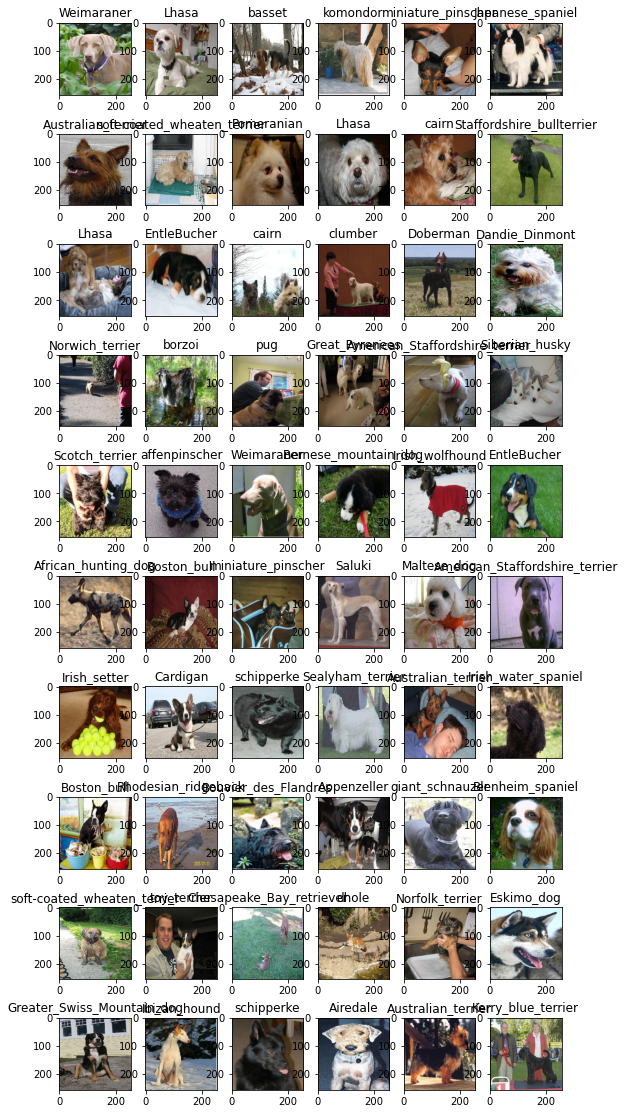

In [23]:
# specify the number of rows and columns you want to see
num_row =10
num_col = 6

# get a segment of the dataset
num = num_row*num_col
images = XSubset[:num]
labels = ySubset[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i])
    ax.set_title(f'{dictDogTypes[labels[i]]}')
#plt.tight_layout()
plt.show()

(<matplotlib.image.AxesImage at 0x7f98456f4fd0>, 3106)

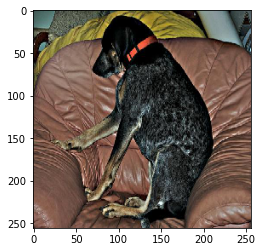

In [24]:
#img = imgs[1049][:,:,::-1] 
index=random.randrange(0,10000)
index=3106
img=XSubset[index]
plt.imshow(img),index

# SIFT

[ WARN:0] global /Users/runner/miniforge3/conda-bld/libopencv_1612623446098/work/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


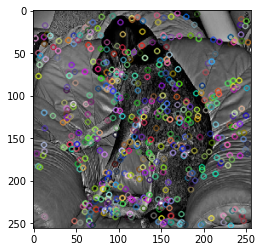

In [25]:
#reading image
#img1 = cv2.imread('drive/MyDrive/Colab Notebooks/Datasets/n02113186_1447.jpg') 
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray1)

#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img,None)
img_1 = cv2.drawKeypoints(gray1,keypoints_1,img)
plt.imshow(img_1)

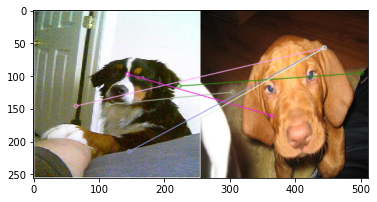

(<matplotlib.image.AxesImage at 0x7f9846a45b20>, None)

In [26]:
img1 = XSubset[6256]
img2 = XSubset[7220]

# SIFT detector
sift = cv2.SIFT_create()
# find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BruteForceMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

# ORB

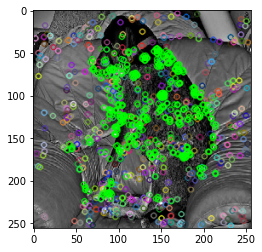

(<matplotlib.image.AxesImage at 0x7f9846ae6a60>, None)

In [27]:
# ORB detector
orb = cv2.ORB_create()
# find keypoints with ORB
kp = orb.detect(img,None)
# compute descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

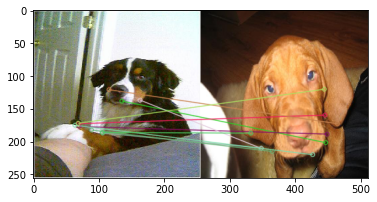

(<matplotlib.image.AxesImage at 0x7f9846b099a0>, None)

In [28]:
img1 = XSubset[6256]
img2 = XSubset[7220]
# ORB detector
orb = cv2.ORB_create()
# find keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

# CNN

In [34]:
# setup parameters
batch_sz = 128  # batch size 
nb_class = 120  # target number of classes
nb_epochs = 15 # training epochs
img_h, img_w = 256, 256  # input dimensions

In [35]:
X_train, X_test, y_train, y_test = train_test_split(XSubset, ySubset, test_size=0.3, random_state=42)

In [36]:
# create generator to center and standardize images
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rescale=1/255.)

# calculate on training dataset
datagen.fit(X_train)

# prepare an iterators to process images
train_iterator = datagen.flow(X_train, y_train, batch_size=64)
test_iterator = datagen.flow(X_test, y_test, batch_size=64)
print(f'Batches train={len(train_iterator)}, test={len(test_iterator)}')

Batches train=110, test=47


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


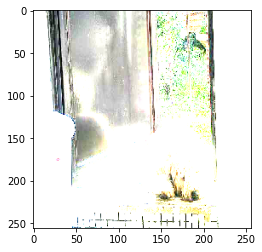

In [37]:
# display sample image from imagedatagenerator
plt.imshow(train_iterator.next()[0][33])

## CUSTOM MODEL

In [38]:
model = create_model_3(256,256)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)      

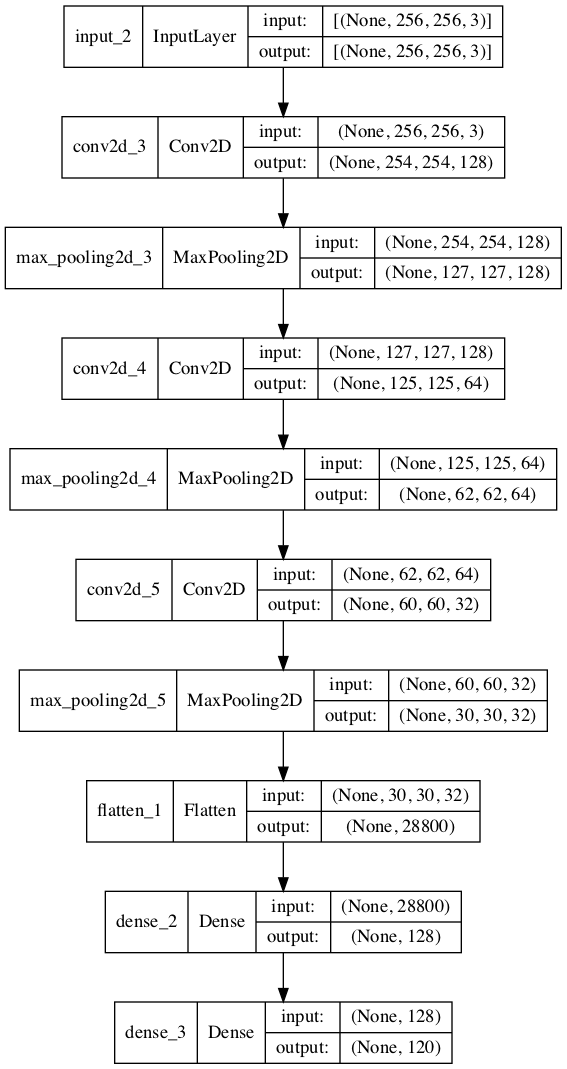

In [39]:
# Displaying model
plot_model(model, show_shapes=True, show_layer_names=True)

In [40]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('cnn.h5')

In [41]:
X_train.shape,y_train.shape

((7000, 256, 256, 3), (7000,))

In [ ]:
%%time
#history=model.fit(X_train, y_train, batch_size=batch_sz, epochs=nb_epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[callback]) # classic
history=model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=nb_epochs,validation_data=(X_test, y_test),callbacks=[callback]) # image preprocessing+generator iterator

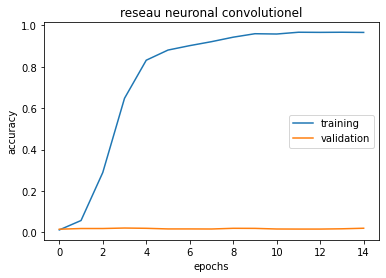

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('reseau neuronal convolutionel')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

In [ ]:
# Evaluate and print accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Test loss: 1112.2236328125
Test accuracy: 0.01966666616499424


In [ ]:
%%time
#model = tf.keras.models.load_model("cnn3")

In [ ]:
model.save('cnn3')

INFO:tensorflow:Assets written to: cnn3/assets


## VGG16

In [ ]:
model_vgg16 = create_model_vgg16(img_w,img_h)

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

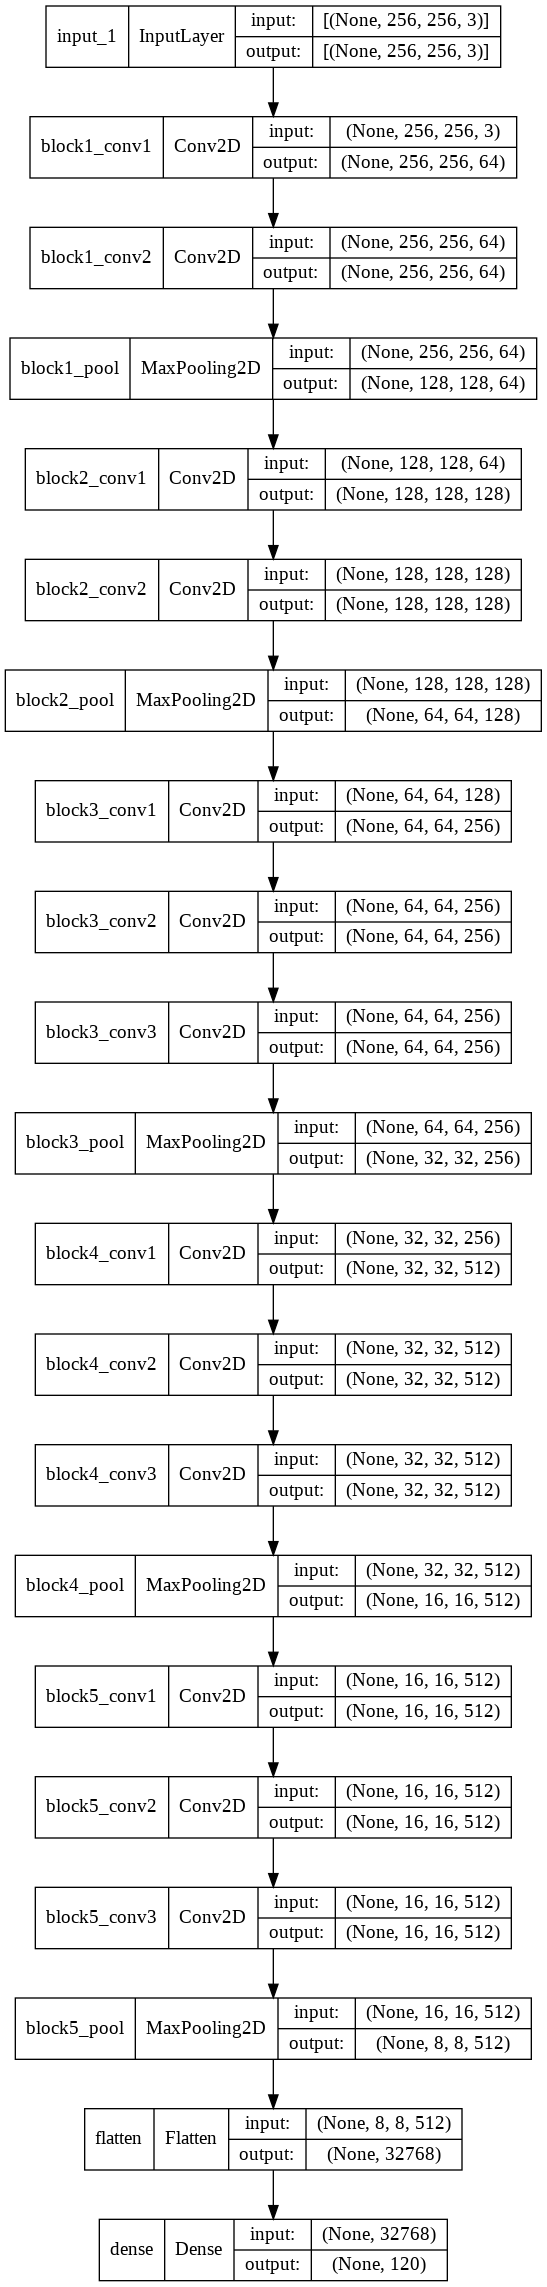

In [ ]:
# Displaying model
plot_model(model_vgg16, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('mnist_cnn_vgg16.h5')

In [ ]:
%%time
# start training
#history=model_vgg16.fit(X_train, y_train,batch_size=batch_sz,epochs=nb_epochs,verbose=1,validation_data=(X_test, y_test), callbacks=[callback])
history=model_vgg16.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=nb_epochs,validation_data=(X_test, y_test),callbacks=[callback]) # image preprocessing+generator iterator

Epoch 1/15
110/110 [==============================] - 401s 4s/step - loss: 5.1335 - accuracy: 0.1969 - val_loss: 107.6943 - val_accuracy: 0.2380
Epoch 2/15
110/110 [==============================] - 401s 4s/step - loss: 0.2049 - accuracy: 0.9450 - val_loss: 96.5423 - val_accuracy: 0.2687
Epoch 3/15
110/110 [==============================] - 402s 4s/step - loss: 0.0343 - accuracy: 0.9946 - val_loss: 94.7152 - val_accuracy: 0.2807
Epoch 4/15
110/110 [==============================] - 402s 4s/step - loss: 0.0123 - accuracy: 0.9993 - val_loss: 92.6819 - val_accuracy: 0.2860
Epoch 5/15
110/110 [==============================] - 403s 4s/step - loss: 0.0140 - accuracy: 0.9984 - val_loss: 92.5855 - val_accuracy: 0.2867
Epoch 6/15
110/110 [==============================] - 412s 4s/step - loss: 0.0170 - accuracy: 0.9981 - val_loss: 91.9315 - val_accuracy: 0.2913
Epoch 7/15
110/110 [==============================] - 403s 4s/step - loss: 0.0106 - accuracy: 0.9987 - val_loss: 93.9717 - val_accuracy

In [ ]:
model_vgg16.save('drive/MyDrive/Colab Notebooks/cnn_vgg16')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/cnn_vgg16/assets


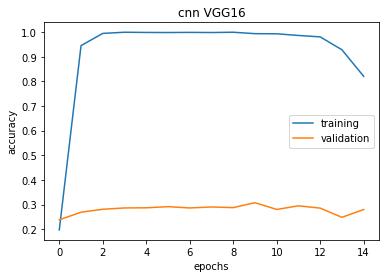

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn VGG16')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

In [ ]:
# Evaluate and print accuracy
score = model_vgg16.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 183.18568420410156
Test accuracy: 0.2796666622161865


## VGG19

In [ ]:
model_vgg19 = create_model_vgg19(img_w,img_h)

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

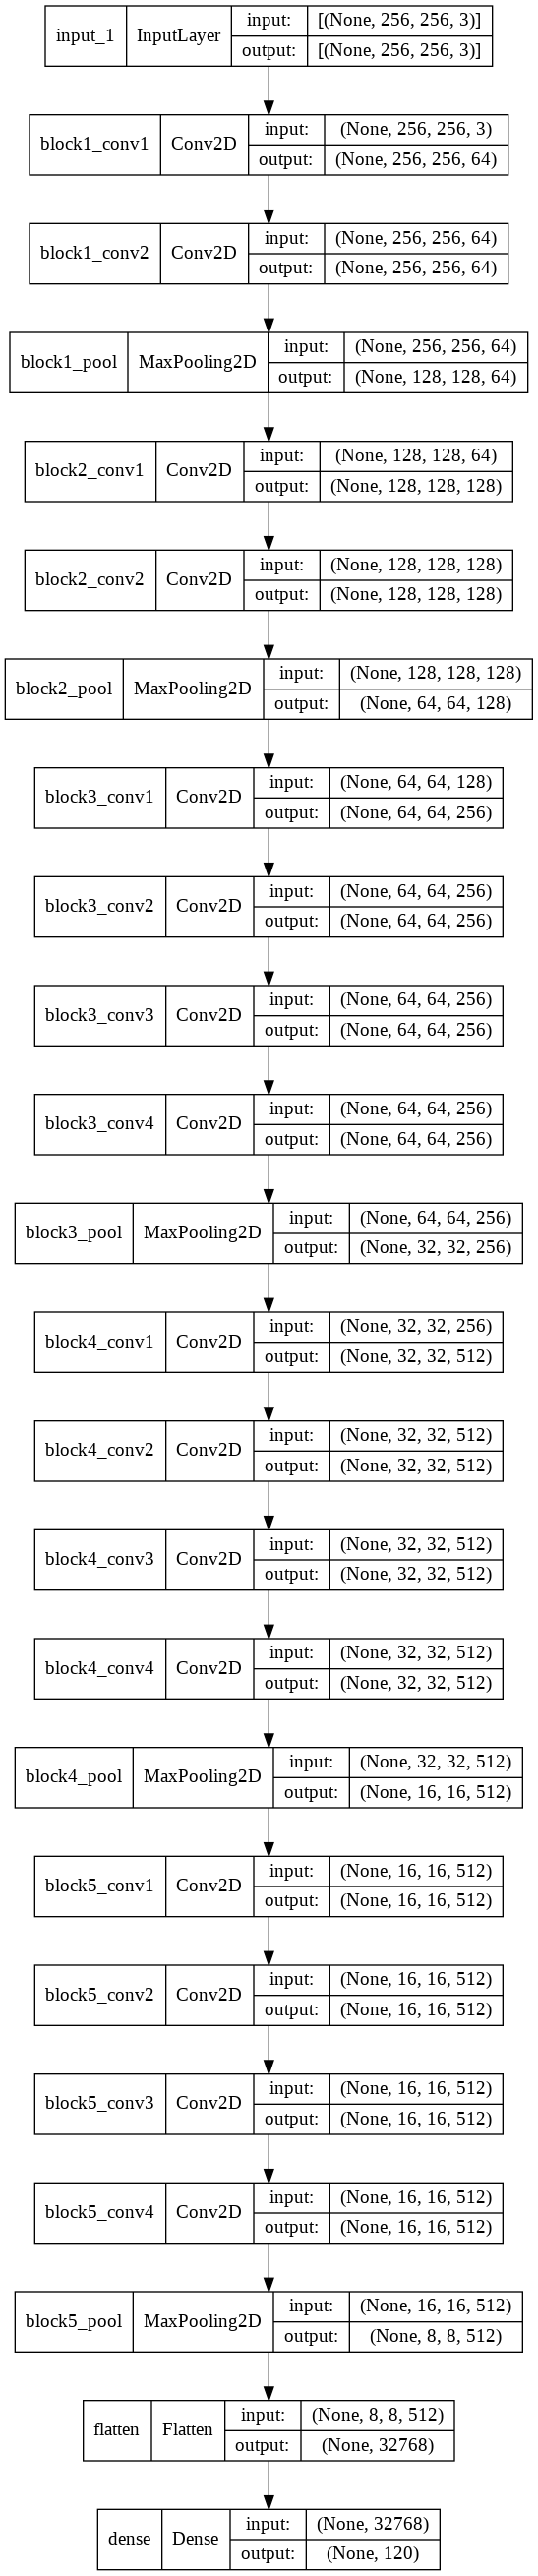

In [ ]:
# Displaying model
plot_model(model_vgg19, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('cnn_vgg19.h5')

In [ ]:
%%time
# start training
#history=model_vgg19.fit(X_train, y_train,batch_size=batch_sz,epochs=nb_epochs,verbose=1,validation_data=(X_test, y_test), callbacks=[callback]) # standard call
history=model_vgg19.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=nb_epochs,validation_data=(X_test, y_test),callbacks=[callback]) # image preprocessing+generator iterator

Epoch 1/15
110/110 [==============================] - 469s 4s/step - loss: 5.0454 - accuracy: 0.2000 - val_loss: 76.2995 - val_accuracy: 0.3123
Epoch 2/15
110/110 [==============================] - 469s 4s/step - loss: 0.2204 - accuracy: 0.9413 - val_loss: 67.6751 - val_accuracy: 0.3710
Epoch 3/15
110/110 [==============================] - 470s 4s/step - loss: 0.0424 - accuracy: 0.9901 - val_loss: 66.4203 - val_accuracy: 0.3790
Epoch 4/15
110/110 [==============================] - 470s 4s/step - loss: 0.0146 - accuracy: 0.9981 - val_loss: 66.9386 - val_accuracy: 0.3813
Epoch 5/15
110/110 [==============================] - 471s 4s/step - loss: 0.0291 - accuracy: 0.9954 - val_loss: 66.5980 - val_accuracy: 0.3910
Epoch 6/15
110/110 [==============================] - 470s 4s/step - loss: 0.0181 - accuracy: 0.9977 - val_loss: 68.3606 - val_accuracy: 0.3823
Epoch 7/15
110/110 [==============================] - 471s 4s/step - loss: 0.0149 - accuracy: 0.9979 - val_loss: 72.2411 - val_accuracy:

In [ ]:
model_vgg19.save('drive/MyDrive/Colab Notebooks/cnn_vgg19')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/cnn_vgg19/assets


In [46]:
model_vgg19=load_model('./cnn_vgg19')

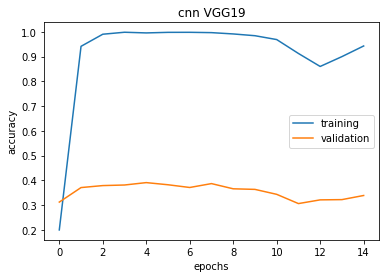

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn VGG19')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

In [ ]:
# Evaluate and print accuracy
score = model_vgg19.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## RESNET50

In [ ]:
model_resnet50 = create_model_resnet50(img_w,img_h)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

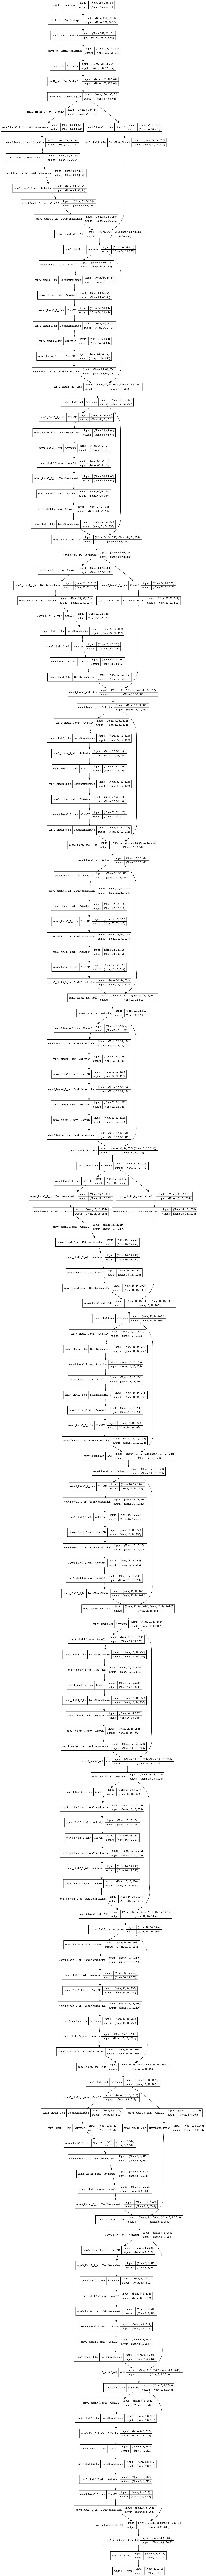

In [ ]:
# Displaying model
plot_model(model_resnet50, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

# To save model after each epoch of training
callback = ModelCheckpoint('cnn_resnet50.h5')

In [ ]:
%%time
# start training
#history=model_resnet50.fit(X_train, y_train,batch_size=batch_sz,epochs=nb_epochs,verbose=1,validation_data=(X_test, y_test), callbacks=[callback])
history=model_resnet50.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=nb_epochs,validation_data=(X_test, y_test),callbacks=[callback]) # image preprocessing+generator iterator

In [ ]:
model_resnet50.save('drive/MyDrive/Colab Notebooks/cnn_resnet50')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/cnn_resnet50/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


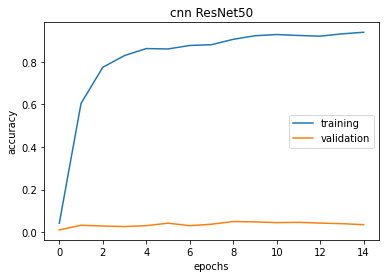

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training' , 'validation'] , loc = 'right')
plt.show()

## Layers visualization

### Filters

In [48]:
model=model_vgg19

In [49]:
for layer in model.layers:    
    if 'conv' in layer.name:            
        filters , bias = layer.get_weights()
        print(layer.name , filters.shape) #filters.shape = A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block3_conv4 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block4_conv4 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)
block5_conv4 (3, 3, 512, 512)


In [50]:
filters.shape[3]

512

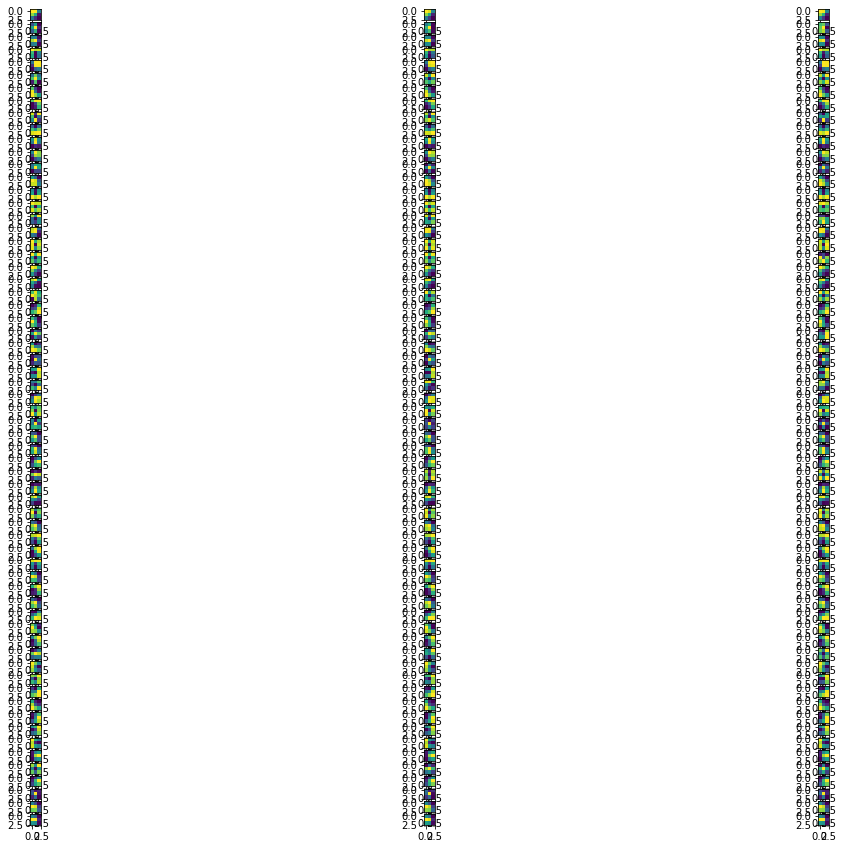

In [55]:
# retrieve weights from the hidden layer
filters , bias = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

#n_filters =32
n_filters=filters.shape[3]
j=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for channel in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,j)
        plt.imshow(f[:,:,channel])
        j+=1
#plot the filters 
plt.show()

### Features

In [56]:
# couches de convolution
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' in layer.name:    
        print(i , layer.name , layer.output.shape)

1 block1_conv1 (None, 256, 256, 64)
2 block1_conv2 (None, 256, 256, 64)
4 block2_conv1 (None, 128, 128, 128)
5 block2_conv2 (None, 128, 128, 128)
7 block3_conv1 (None, 64, 64, 256)
8 block3_conv2 (None, 64, 64, 256)
9 block3_conv3 (None, 64, 64, 256)
10 block3_conv4 (None, 64, 64, 256)
12 block4_conv1 (None, 32, 32, 512)
13 block4_conv2 (None, 32, 32, 512)
14 block4_conv3 (None, 32, 32, 512)
15 block4_conv4 (None, 32, 32, 512)
17 block5_conv1 (None, 16, 16, 512)
18 block5_conv2 (None, 16, 16, 512)
19 block5_conv3 (None, 16, 16, 512)
20 block5_conv4 (None, 16, 16, 512)


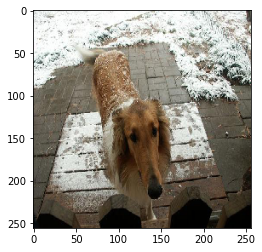

In [57]:
img=XSubset[77]
plt.imshow(img)
image=(np.expand_dims(img, axis=0)).astype(float)
image=std_image(image)

In [58]:
len(model.layers)

24

In [59]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)-2]]
# couches d'activation avec entrées et sorties
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs) #puts together the input and output functions of the CNN model

In [60]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [61]:
#calculating features
activations = activation_model.predict(image)

In [62]:
for activation_layer in activation_model.layers:
    print(f"Shape of {activation_layer.name} -> {activation_layer.output.shape}")

Shape of input_1 -> (None, 256, 256, 3)
Shape of block1_conv1 -> (None, 256, 256, 64)
Shape of block1_conv2 -> (None, 256, 256, 64)
Shape of block1_pool -> (None, 128, 128, 64)
Shape of block2_conv1 -> (None, 128, 128, 128)
Shape of block2_conv2 -> (None, 128, 128, 128)
Shape of block2_pool -> (None, 64, 64, 128)
Shape of block3_conv1 -> (None, 64, 64, 256)
Shape of block3_conv2 -> (None, 64, 64, 256)
Shape of block3_conv3 -> (None, 64, 64, 256)
Shape of block3_conv4 -> (None, 64, 64, 256)
Shape of block3_pool -> (None, 32, 32, 256)
Shape of block4_conv1 -> (None, 32, 32, 512)
Shape of block4_conv2 -> (None, 32, 32, 512)
Shape of block4_conv3 -> (None, 32, 32, 512)
Shape of block4_conv4 -> (None, 32, 32, 512)
Shape of block4_pool -> (None, 16, 16, 512)
Shape of block5_conv1 -> (None, 16, 16, 512)
Shape of block5_conv2 -> (None, 16, 16, 512)
Shape of block5_conv3 -> (None, 16, 16, 512)
Shape of block5_conv4 -> (None, 16, 16, 512)
Shape of block5_pool -> (None, 8, 8, 512)


In [63]:
len(activations), range(len(activations)-1)

(22, range(0, 21))

(1, 256, 256, 64) 64


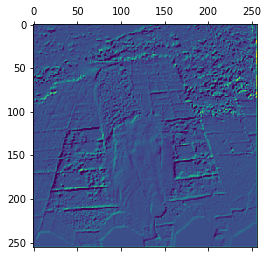

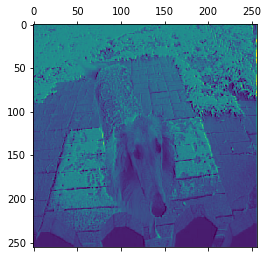

In [64]:
# Getting Activations of first layer
nth_layer_activation = activations[1]
  
# shape of first layer activation
print(nth_layer_activation.shape, nth_layer_activation.shape[3])
  
# 6th channel of the image after first layer of convolution is applied
plt.matshow(nth_layer_activation[0, :, :, 0], cmap ='viridis')
  
# 15th channel of the image after first layer of convolution is applied
plt.matshow(nth_layer_activation[0, :, :, 2], cmap ='viridis')

In [65]:
range(1,nth_layer_activation.shape[3]), 32//8, 32%8

(range(1, 64), 4, 0)

(1, 256, 256, 64) 63


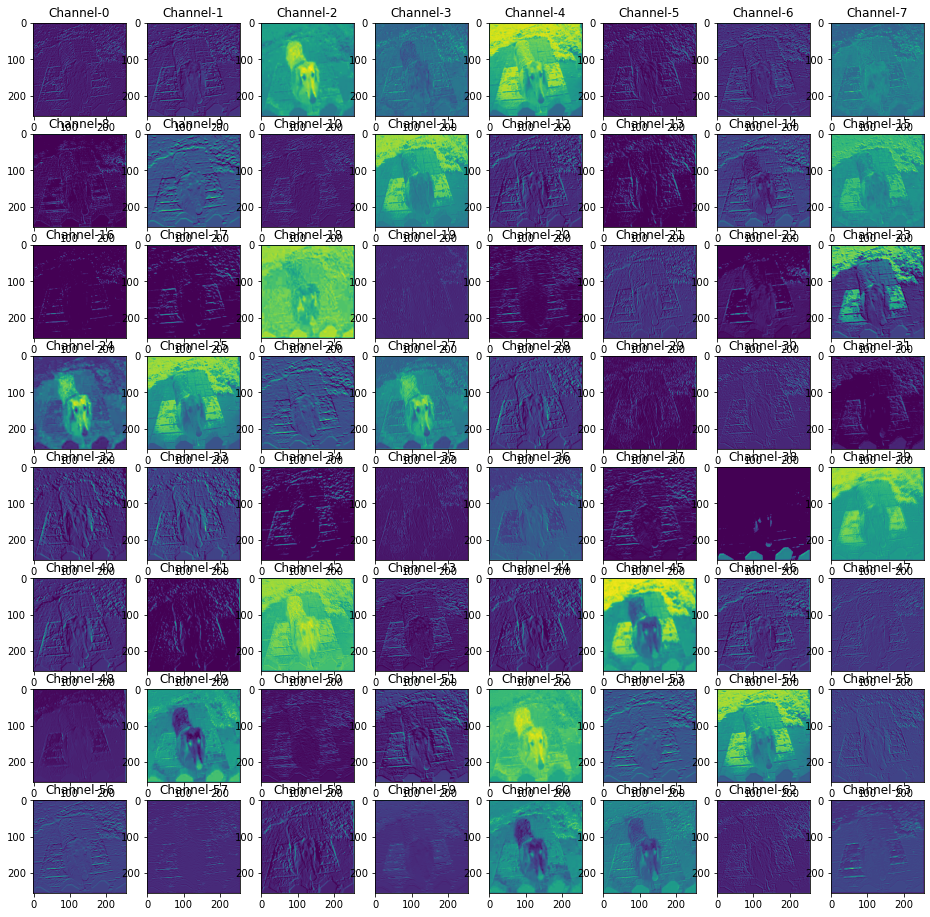

In [70]:
n=2
num_row=8
num_col=8


# Gettubg activation of nth layer
nth_layer_activation = activations[n]
  
# shape of nth layer activation
print(nth_layer_activation.shape, nth_layer_activation.shape[3]-1)

# plot activation layer's channels
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))

for c in range(nth_layer_activation.shape[3]):
    ax = axes[c//num_col, c%num_col]
    ax.imshow(nth_layer_activation[0, :, :, c], cmap='viridis')
    ax.set_title(f'Channel-{c}')
plt.show()